In [91]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from scipy.ndimage import gaussian_filter1d


import matplotlib.pyplot as plt
from scipy.stats import norm

# pd.set_option('display.max_columns', None)
# pd.set_option('display.max_rows', None)

# 被験者ID
subject_id = "001"
# 実験番号
experiment_id = "001"

# IVT法のパラメータ
VELOCITY_THRESHOLD = 30 # deg
DURATION_THRESHOLD_MS = 100  # ms

eye_df = pd.read_csv(f"exported_csv/eye_df_id{subject_id}-{experiment_id}.csv")
sampling_df = pd.read_csv(f"exported_csv/sampling_df_id{subject_id}-{experiment_id}.csv")

In [92]:

# モニターサイズ(物理)
monitor_width_cm = 47.6
monitor_height_cm = 26.8
# モニター解像度(px)
monitor_resolution_px = (1920, 1080)
# 視距離(cm)
viewer_distance_cm = 60.0

# cm/pxの変換係数
cm_per_pixel_x = monitor_width_cm / monitor_resolution_px[0]
cm_per_pixel_y = monitor_height_cm / monitor_resolution_px[1]

# ディスプレイ中心を(0, 0)とするための変換
eye_df["gx_centered"] = eye_df["gx"] - 0.5
eye_df["gy_centered"] = eye_df["gy"] - 0.5

# 中心(0,0)での物理距離変換
eye_df["x_cm"] = eye_df["gx_centered"] * monitor_resolution_px[0] * cm_per_pixel_x
eye_df["y_cm"] = eye_df["gy_centered"] * monitor_resolution_px[1] * cm_per_pixel_y

# 視野角の計算
eye_df["x_deg"] = np.degrees(np.arctan2(eye_df["x_cm"], viewer_distance_cm))
eye_df["y_deg"] = np.degrees(np.arctan2(eye_df["y_cm"], viewer_distance_cm))

# データの有効性
eye_df["is_valid"] = eye_df["validity_sum"] > 1

print(eye_df.head())


         gx        gy     epoch_sec        hhmmss  validity_sum  trial  \
0       NaN       NaN  1.732521e+09  16:49:03.491             0     -1   
1  0.476050  0.816155  1.732521e+09  16:49:03.506             2     -1   
2  0.490610  0.818481  1.732521e+09  16:49:03.522             2     -1   
3  0.520527  0.754540  1.732521e+09  16:49:03.538             2     -1   
4  0.507679  0.780874  1.732521e+09  16:49:03.538             2     -1   

   gx_centered  gy_centered      x_cm      y_cm     x_deg     y_deg  is_valid  
0          NaN          NaN       NaN       NaN       NaN       NaN     False  
1    -0.023950     0.316155 -1.140020  8.472954 -1.088508  8.037926      True  
2    -0.009390     0.318481 -0.446964  8.535291 -0.426811  8.096281      True  
3     0.020527     0.254540  0.977085  6.821672  0.932965  6.486364      True  
4     0.007679     0.280874  0.365520  7.527423  0.349042  7.150799      True  


In [93]:
def interpolate_missing(df, time_col="epoch_sec", max_gap_ms=100):
    df= df.copy()
    df["valid"]= df["is_valid"]
    df["interp_x"]= np.nan
    df["interp_y"]= np.nan

    # 有効データを代入
    df.loc[df["valid"], "interp_x"] = df.loc[df["valid"], "x_deg"]
    df.loc[df["valid"], "interp_y"] = df.loc[df["valid"], "y_deg"]
    
    # 内部のみ線形補完
    df["interp_x"] = df["interp_x"].interpolate(limit_area="inside")
    df["interp_y"] = df["interp_y"].interpolate(limit_area="inside")
    
    # 無効区間の連続ブロックを取得
    invalid_mask = ~df["valid"]
    group_id = (invalid_mask != invalid_mask.shift()).cumsum()
    invalid_blocks = df[invalid_mask].groupby(group_id)

    for _, block in invalid_blocks:
        if len(block) == 0:
            continue
        t_start = block[time_col].iloc[0]
        t_end = block[time_col].iloc[-1]
        duration_ms = (t_end - t_start) * 1000
        if duration_ms > max_gap_ms:
            # 100ms超えたら補完結果をNaNに戻す
            df.loc[block.index, ["interp_x", "interp_y"]] = np.nan
    

    return df
    

In [94]:
def apply_gaussian_filter_by_block(df, col_x="interp_x", col_y="interp_y", sigma=1.0):
    df = df.copy()
    df["valid"]= df["is_valid"]
    df["filtered_x"] = np.nan
    df["filtered_y"] = np.nan

    # 有効なデータ（NaNでない）だけを連続ブロックとして抽出
    valid_mask = df[col_x].notna() & df[col_y].notna()
    block_id = (valid_mask != valid_mask.shift()).cumsum()
    blocks = df[valid_mask].groupby(block_id)

    for _, block in blocks:
        idx = block.index
        smoothed_x = gaussian_filter1d(block[col_x], sigma=sigma)
        smoothed_y = gaussian_filter1d(block[col_y], sigma=sigma)
        df.loc[idx, "filtered_x"] = smoothed_x
        df.loc[idx, "filtered_y"] = smoothed_y

    return df


In [95]:
def detect_fixations_ivt(df, velocity_threshold=VELOCITY_THRESHOLD, duration_threshold_ms=DURATION_THRESHOLD_MS):
    fixations = []
    timestamps = df["epoch_sec"].to_numpy()
    xs = df["filtered_x"].to_numpy()
    ys = df["filtered_y"].to_numpy()
    
    # 速度（deg/s）を計算
    velocities = np.sqrt(np.diff(xs)**2 + np.diff(ys)**2) / np.diff(timestamps)
    velocities = np.insert(velocities, 0, 0)  # 最初の点の速度は0とする

    in_fixation = False
    start_idx = 0
   
    for i in range(len(df)):
        if np.isnan(xs[i]) or np.isnan(ys[i]):
            if in_fixation:
                # 注視の終了
                in_fixation = False
                t_start = timestamps[start_idx]
                t_end = timestamps[i - 1]
                duration = (t_end - t_start) * 1000
                if duration >= duration_threshold_ms:
                    fixations.append({
                        "start_time": t_start,
                        "end_time": t_end,
                        "duration_ms": duration,
                        "x_mean_deg": np.mean(xs[start_idx:i]),
                        "y_mean_deg": np.mean(ys[start_idx:i]),
                    })
            continue

        if velocities[i] < velocity_threshold:
            if not in_fixation:
                in_fixation = True
                start_idx = i
        else:
            if in_fixation:
                in_fixation = False
                t_start = timestamps[start_idx]
                t_end = timestamps[i - 1]
                duration = (t_end - t_start) * 1000
                if duration >= duration_threshold_ms:
                    fixations.append({
                        "start_time": t_start,
                        "end_time": t_end,
                        "duration_ms": duration,
                        "x_mean_deg": np.mean(xs[start_idx:i]),
                        "y_mean_deg": np.mean(ys[start_idx:i]),
                    })

    # 最後が注視で終わっていた場合
    if in_fixation:
        t_start = timestamps[start_idx]
        t_end = timestamps[-1]
        duration = (t_end - t_start) * 1000
        if duration >= duration_threshold_ms:
            fixations.append({
                "start_time": t_start,
                "end_time": t_end,
                "duration_ms": duration,
                "x_mean_deg": np.mean(xs[start_idx:]),
                "y_mean_deg": np.mean(ys[start_idx:]),
            })

    return pd.DataFrame(fixations)


In [96]:
def deg_to_px(x_mean_deg, y_mean_deg):
    x_cm = np.tan(np.radians(x_mean_deg)) * viewer_distance_cm
    y_cm = np.tan(np.radians(y_mean_deg)) * viewer_distance_cm
    x_mean_px = (x_cm / cm_per_pixel_x) + (monitor_resolution_px[0] / 2)
    y_mean_px = (y_cm / cm_per_pixel_y) + (monitor_resolution_px[1] / 2)
    return x_mean_px, y_mean_px


**************************************
      start_time      end_time  duration_ms  x_mean_deg  y_mean_deg  trial  \
0   1.732521e+09  1.732521e+09   220.999956   -2.701195    0.061110    0.0   
1   1.732521e+09  1.732521e+09   255.000114   -0.261348    0.076404    0.0   
2   1.732521e+09  1.732521e+09   144.000053   -0.600253    0.006609    0.0   
3   1.732521e+09  1.732521e+09   127.000093   -1.290640    0.722389    0.0   
4   1.732521e+09  1.732521e+09   255.000114   -0.287186    0.113089    0.0   
..           ...           ...          ...         ...         ...    ...   
77  1.732521e+09  1.732521e+09   127.000093   -4.970187   -9.103673    0.0   
78  1.732521e+09  1.732521e+09   143.999815   -4.961952   -9.034223    0.0   
79  1.732521e+09  1.732521e+09   127.000093   -2.895772  -10.597369    0.0   
80  1.732521e+09  1.732521e+09   526.999950   -6.632317   -8.952927    0.0   
81  1.732521e+09  1.732521e+09   238.999844   -7.300362   -7.489694    0.0   

          x_px        y_

C:\Users\OWNER\AppData\Local\Temp\ipykernel_11072\2039497765.py:8: RuntimeWarning: divide by zero encountered in divide
  velocities = np.sqrt(np.diff(xs)**2 + np.diff(ys)**2) / np.diff(timestamps)


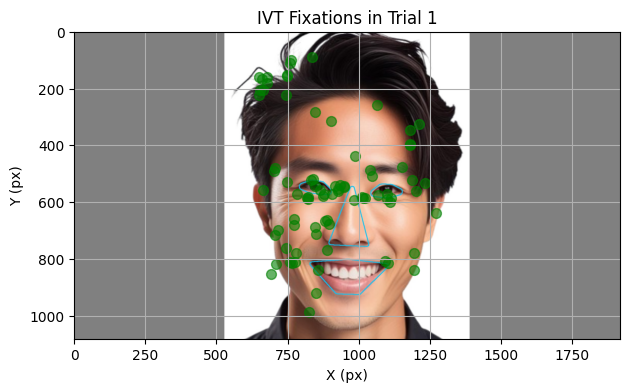

C:\Users\OWNER\AppData\Local\Temp\ipykernel_11072\2039497765.py:8: RuntimeWarning: divide by zero encountered in divide
  velocities = np.sqrt(np.diff(xs)**2 + np.diff(ys)**2) / np.diff(timestamps)


**************************************
      start_time      end_time  duration_ms  x_mean_deg  y_mean_deg  trial  \
0   1.732521e+09  1.732521e+09   143.999815   -0.173777    0.251407    1.0   
1   1.732521e+09  1.732521e+09   271.000147   -0.121862    0.276201    1.0   
2   1.732521e+09  1.732521e+09   240.000010   -0.345746    1.572108    1.0   
3   1.732521e+09  1.732521e+09   207.000017   -3.376295    2.005385    1.0   
4   1.732521e+09  1.732521e+09   489.000082    0.003921    0.297249    1.0   
..           ...           ...          ...         ...         ...    ...   
74  1.732521e+09  1.732521e+09   141.999960   -0.194736    5.532009    1.0   
75  1.732521e+09  1.732521e+09   461.999893    0.263720    5.774865    1.0   
76  1.732521e+09  1.732521e+09   160.000086   -2.386992    0.941937    1.0   
77  1.732521e+09  1.732521e+09   256.000042   -1.791712    0.759581    1.0   
78  1.732521e+09  1.732521e+09   126.999855   -1.654897    0.583599    1.0   

          x_px        y_

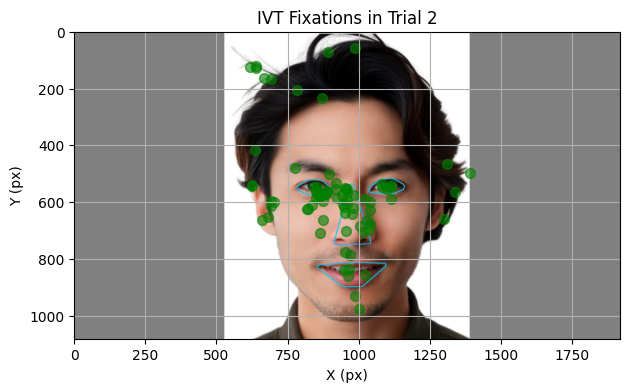

C:\Users\OWNER\AppData\Local\Temp\ipykernel_11072\2039497765.py:8: RuntimeWarning: divide by zero encountered in divide
  velocities = np.sqrt(np.diff(xs)**2 + np.diff(ys)**2) / np.diff(timestamps)


**************************************
      start_time      end_time  duration_ms  x_mean_deg  y_mean_deg  trial  \
0   1.732521e+09  1.732521e+09   128.000021   -0.144540    0.750272    2.0   
1   1.732521e+09  1.732521e+09   159.000158   -6.567480    1.104962    2.0   
2   1.732521e+09  1.732521e+09   223.000050   -1.401667    1.220140    2.0   
3   1.732521e+09  1.732521e+09   207.000017   -0.168938    0.407317    2.0   
4   1.732521e+09  1.732521e+09   128.000021   -1.418710    0.800743    2.0   
..           ...           ...          ...         ...         ...    ...   
66  1.732521e+09  1.732521e+09   365.999937   -4.240847    1.991268    2.0   
67  1.732521e+09  1.732521e+09   319.000006   -5.118426   -8.573317    2.0   
68  1.732521e+09  1.732521e+09   127.000093   -8.472271   -3.695915    2.0   
69  1.732521e+09  1.732521e+09   160.000086   -6.631884    0.037042    2.0   
70  1.732521e+09  1.732521e+09   779.000044    1.067358    6.590801    2.0   

           x_px        y

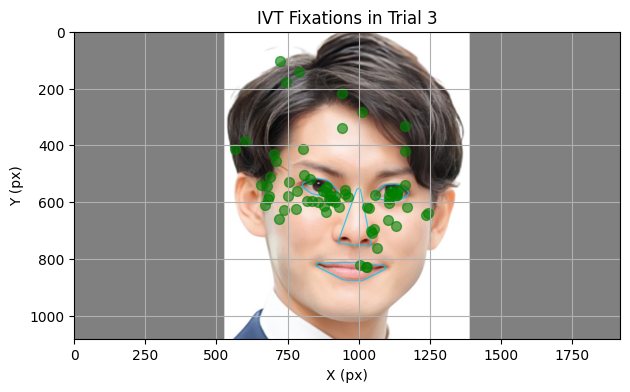

C:\Users\OWNER\AppData\Local\Temp\ipykernel_11072\2039497765.py:8: RuntimeWarning: divide by zero encountered in divide
  velocities = np.sqrt(np.diff(xs)**2 + np.diff(ys)**2) / np.diff(timestamps)


**************************************
      start_time      end_time  duration_ms  x_mean_deg  y_mean_deg  trial  \
0   1.732521e+09  1.732521e+09   745.999813    0.329405    0.218773    3.0   
1   1.732521e+09  1.732521e+09   346.999884   -0.574604    0.943991    3.0   
2   1.732521e+09  1.732521e+09   223.999977   -0.682627    0.919487    3.0   
3   1.732521e+09  1.732521e+09   127.000093    0.020048   -0.151697    3.0   
4   1.732521e+09  1.732521e+09   331.000090   -0.308896    7.471026    3.0   
..           ...           ...          ...         ...         ...    ...   
65  1.732521e+09  1.732521e+09   174.999952    9.268300   -0.519579    3.0   
66  1.732521e+09  1.732521e+09   416.000128    8.018512    0.177192    3.0   
67  1.732521e+09  1.732521e+09   237.999916   -7.842159    1.928337    3.0   
68  1.732521e+09  1.732521e+09   223.000050   -7.777403    1.380595    3.0   
69  1.732521e+09  1.732521e+09   686.000109   -8.333592    0.181020    3.0   

           x_px        y

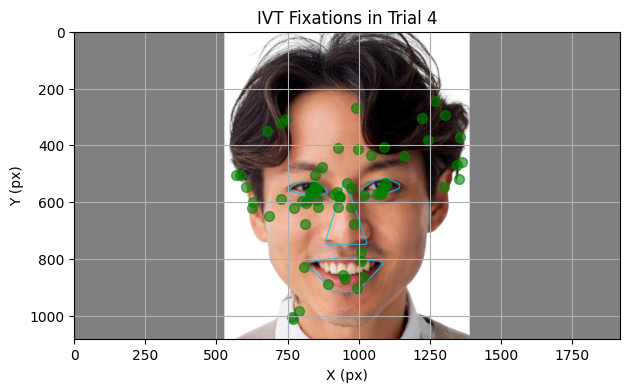

C:\Users\OWNER\AppData\Local\Temp\ipykernel_11072\2039497765.py:8: RuntimeWarning: divide by zero encountered in divide
  velocities = np.sqrt(np.diff(xs)**2 + np.diff(ys)**2) / np.diff(timestamps)


**************************************
      start_time      end_time  duration_ms  x_mean_deg  y_mean_deg  trial  \
0   1.732521e+09  1.732521e+09   159.999847   -0.142008    0.705150    4.0   
1   1.732521e+09  1.732521e+09   336.000204    3.883857    0.618011    4.0   
2   1.732521e+09  1.732521e+09   174.999952    8.116851    2.051201    4.0   
3   1.732521e+09  1.732521e+09   240.000010    8.805586    2.368745    4.0   
4   1.732521e+09  1.732521e+09   128.000021    8.804836    1.718867    4.0   
..           ...           ...          ...         ...         ...    ...   
58  1.732521e+09  1.732521e+09   110.999823  -10.310485   -2.413019    4.0   
59  1.732521e+09  1.732521e+09   256.000042   -1.299591    1.970391    4.0   
60  1.732521e+09  1.732521e+09   159.999847   -0.923641    1.122846    4.0   
61  1.732521e+09  1.732521e+09   207.000017    4.240770    1.711977    4.0   
62  1.732521e+09  1.732521e+09   207.000017    8.024796    0.907637    4.0   

           x_px        y

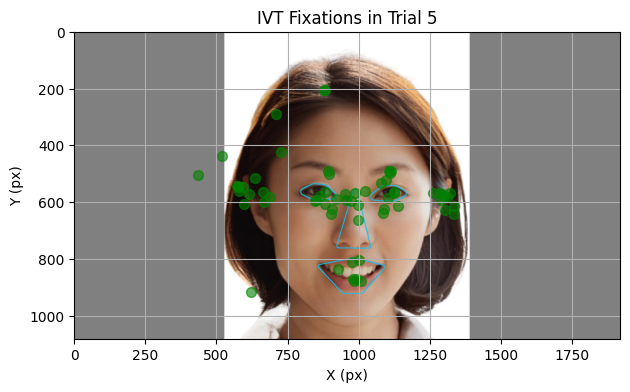

C:\Users\OWNER\AppData\Local\Temp\ipykernel_11072\2039497765.py:8: RuntimeWarning: divide by zero encountered in divide
  velocities = np.sqrt(np.diff(xs)**2 + np.diff(ys)**2) / np.diff(timestamps)


**************************************
      start_time      end_time  duration_ms  x_mean_deg  y_mean_deg  trial  \
0   1.732521e+09  1.732521e+09   301.000118   -3.205566    1.477268    5.0   
1   1.732521e+09  1.732521e+09   158.999920    0.340726    0.445424    5.0   
2   1.732521e+09  1.732521e+09   111.999989   -0.089379    1.315119    5.0   
3   1.732521e+09  1.732521e+09   125.000000    0.092269    1.905050    5.0   
4   1.732521e+09  1.732521e+09   253.000021   -1.344626    0.913061    5.0   
..           ...           ...          ...         ...         ...    ...   
72  1.732521e+09  1.732521e+09   398.000002   -1.827053    0.144032    5.0   
73  1.732521e+09  1.732521e+09   255.000114   -2.704490    1.629813    5.0   
74  1.732521e+09  1.732521e+09   223.999977   -2.569815    0.830068    5.0   
75  1.732521e+09  1.732521e+09   494.999886   -2.657101    0.472949    5.0   
76  1.732521e+09  1.732521e+09   111.999989    1.990122    2.024923    5.0   

           x_px        y

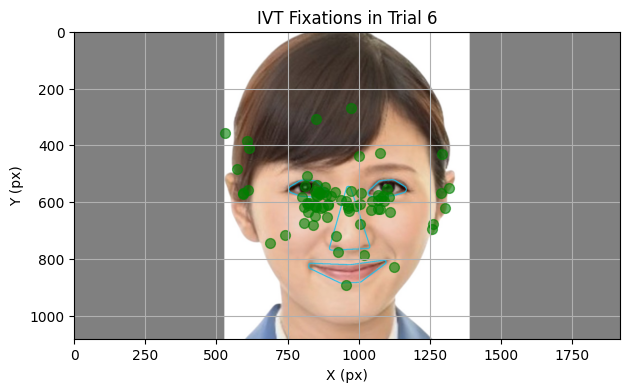

C:\Users\OWNER\AppData\Local\Temp\ipykernel_11072\2039497765.py:8: RuntimeWarning: divide by zero encountered in divide
  velocities = np.sqrt(np.diff(xs)**2 + np.diff(ys)**2) / np.diff(timestamps)


**************************************
      start_time      end_time  duration_ms  x_mean_deg  y_mean_deg  trial  \
0   1.732521e+09  1.732521e+09   829.999924   -0.466628    0.689172    6.0   
1   1.732521e+09  1.732521e+09   159.999847   -0.101608    1.234832    6.0   
2   1.732521e+09  1.732521e+09   207.999945    0.196041    0.410129    6.0   
3   1.732521e+09  1.732521e+09   240.000010   -0.796558    0.416029    6.0   
4   1.732521e+09  1.732521e+09   190.000057   -0.426814    0.343337    6.0   
..           ...           ...          ...         ...         ...    ...   
58  1.732521e+09  1.732521e+09   349.999905   -7.085170    0.325817    6.0   
59  1.732521e+09  1.732521e+09   480.000019   -8.546161   -0.963244    6.0   
60  1.732522e+09  1.732522e+09   144.000053   -5.592089    1.233239    6.0   
61  1.732522e+09  1.732522e+09   206.000090    3.130200    2.004306    6.0   
62  1.732522e+09  1.732522e+09   207.000017    2.752699    6.417537    6.0   

           x_px        y

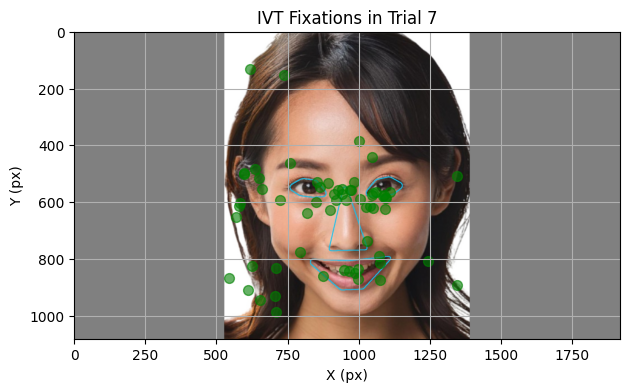

C:\Users\OWNER\AppData\Local\Temp\ipykernel_11072\2039497765.py:8: RuntimeWarning: divide by zero encountered in divide
  velocities = np.sqrt(np.diff(xs)**2 + np.diff(ys)**2) / np.diff(timestamps)


**************************************
      start_time      end_time  duration_ms  x_mean_deg  y_mean_deg  trial  \
0   1.732522e+09  1.732522e+09   203.999996   -0.882664    0.565218    7.0   
1   1.732522e+09  1.732522e+09   414.999962   -3.678135    3.092995    7.0   
2   1.732522e+09  1.732522e+09   302.000046   -0.284989    0.512084    7.0   
3   1.732522e+09  1.732522e+09   141.000032   11.077852    6.579722    7.0   
4   1.732522e+09  1.732522e+09   191.999912    2.144795    0.327785    7.0   
5   1.732522e+09  1.732522e+09   160.000086    2.550286    0.714387    7.0   
6   1.732522e+09  1.732522e+09   268.999815    0.243582   -3.039153    7.0   
7   1.732522e+09  1.732522e+09   207.999945    1.983200   -4.436525    7.0   
8   1.732522e+09  1.732522e+09   158.999920    2.928394    0.493966    7.0   
9   1.732522e+09  1.732522e+09   160.000086   -2.460793   -0.102565    7.0   
10  1.732522e+09  1.732522e+09   409.999847   -2.165057   -4.059210    7.0   
11  1.732522e+09  1.73252

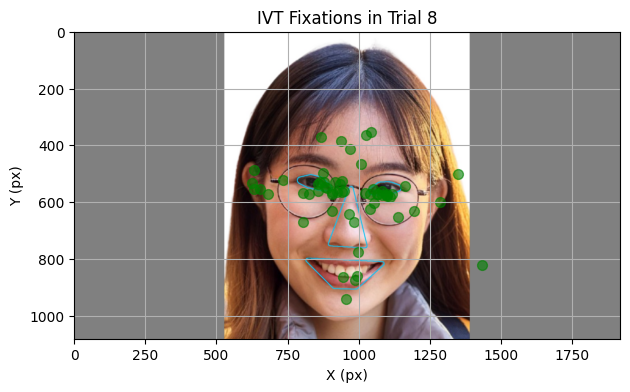

In [97]:
all_fixations = []

for _, row in sampling_df.iterrows():
    t_start = row["start_sec"]
    t_end = row["end_sec"]
    trial_num = row["trial"]

    trial_df = eye_df[(eye_df["epoch_sec"] >= t_start) & (eye_df["epoch_sec"] <= t_end)]
    interp_df = interpolate_missing(trial_df)
    filtered_df = apply_gaussian_filter_by_block(interp_df)
    fix_df = detect_fixations_ivt(filtered_df)

    if fix_df.empty:
        print(f"Trial {trial_num}: No fixations detected.")
        continue

    fix_df["trial"] = trial_num
    fix_df["x_px"], fix_df["y_px"] = deg_to_px(fix_df["x_mean_deg"], fix_df["y_mean_deg"])
    all_fixations.append(fix_df)
    
    print("**************************************")
    print(fix_df)
    print(len(fix_df))

    # 背景画像を読み込み
    img = mpimg.imread(f"output_aoi/1-{int(trial_num)+1}.jpg")  # 例: "background.png"

    # 図の作成
    fig, ax = plt.subplots()

    # 背景画像の表示（軸にフィットさせて）
    ax.imshow(img, extent=[0, 1920, 1080, 0])  # 上下反転（y軸を上→下に）

    # 散布図の描画（fix_dfは事前に用意）
    ax.scatter(fix_df["x_px"], fix_df["y_px"], alpha=0.6, c='green', s=50)

    # 軸設定（アスペクト比保持）
    ax.set_xlim(0, 1920)
    ax.set_ylim(1080, 0)  # y軸を反転
    ax.set_box_aspect(1080 / 1920)  # 縦横比を固定

    # ラベルや装飾
    ax.set_title(f"IVT Fixations in Trial {int(trial_num + 1)}")
    ax.set_xlabel("X (px)")
    ax.set_ylabel("Y (px)")
    ax.grid(True)

    # レイアウト調整＆表示
    plt.tight_layout()
    plt.show()



In [98]:
# new1_df=interpolate_missing(eye_df)

# new2_df=apply_gaussian_filter_by_block(new1_df)

# new3_df=detect_fixations_ivt(new2_df)

# deg_to_px(new3_df["x_mean_deg"], new3_df["y_mean_deg"])